1. Correlation relationship


2. Multi-variable Normal Estimation — Joint Estimation


3. Do more days — more precise

In [1]:
import pandas as pd

import numpy as np

import os,sys


from shapely.geometry import Point, Polygon

import copy


from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import time


from scipy.stats import pearsonr

In [2]:
'''

'Total Number of Shifts', Sum

'Average Order Number', Avg

'Average Shift Duration (sec)', Avg

'Average Occupied Time (sec)', Avg

'First Shift Start Time', No

'Average Occupied Distance(m)' Avg

'''

def Get_sort(a,b,idx):

    a, b = zip(*sorted(zip(a, b)))
    
    if idx==0: 
        return list(a)
    else:  
        return list(b)

def Get_Shift(Startstamp,Endstamp,Duration,Distance):
    
    Result=list()
    
    if len(Startstamp)==1:
        
        Result.append([1,1,Duration[0],Duration[0],Startstamp[0],Endstamp[0],Distance[0]])
        
    else:
        
        s=0
        
        i=0
        
        j=1
        
        order_num=0
        
        occupied_duration=0
        
        occupied_distance=0
        
        while j<len(Startstamp):
            
            order_num+=1
                
            occupied_duration+=Duration[i]

            occupied_distance+=Distance[i]
            
            if Startstamp[j]-Endstamp[i]<3600*2:
                
                if j==len(Startstamp)-1:
                    
                    shift_duration=Endstamp[j]-Startstamp[s]
                    
                    order_num+=1
                
                    occupied_duration+=Duration[j]

                    occupied_distance+=Distance[j]
                    
                    Result.append([1,order_num,shift_duration,occupied_duration,Startstamp[s],Endstamp[j],occupied_distance])
                    
                i+=1
                
                j+=1
                
            else:
                
                shift_duration=Endstamp[i]-Startstamp[s]
                
                Result.append([1,order_num,shift_duration,occupied_duration,Startstamp[s],Endstamp[i],occupied_distance])
                
                order_num=0
                
                occupied_duration=0
                
                occupied_distance=0
                
                s=j
                
                i=j
                
                j+=1
                
    return Result
                
def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    ) 

Get_hour=lambda x:int(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[11:13])+float(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[14:16])/60.0

Get_3600=lambda x:round(x/3600.0,2)

Get_10=lambda x:round(x/10.0,2)


# Param

In [3]:
Load_path='./Data/GAIA/'

Summary_path='./Data/Summary/'

#  Data Collection and Summary

In [4]:
# Summary_Df=pd.DataFrame([],columns=['Driver_id', 'Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time','End Time','Occupied Distance(m)'])

# date_range=[str(dt) for dt in range(20161101,20161115,1)]



# for dt in date_range:

#     GPS_Df=pd.read_csv(os.path.join(Load_path,'gps_'+dt+'.csv'),header=None,names=['Driver_id','Order_id',\
#                                                                                    'Timestamp','Longitude',\
#                                                                                    'Latitude'])

#     GPS_Df=GPS_Df.drop_duplicates(subset=['Driver_id','Order_id'])

#     GPS_Df=GPS_Df.reset_index(drop=True)

#     GPS_Df=GPS_Df[['Driver_id','Order_id']]


#     Order_Df=pd.read_csv(os.path.join(Load_path,'order_'+dt+'.csv'),header=None,names=['Order_id','Startstamp','Endstamp',\
#                                                                                        'Pickup_Longitude','Pickup_Latitude',\
#                                                                                        'Dropoff_Longitude','Dropoff_Latitude'])

#     Get_distance=lambda lng1,lat1,lng2,lat2:int(Point(lng1,lat1).distance(Point(lng2,lat2))*111000)

#     Order_Df['Duration']=Order_Df.apply(lambda x:x['Endstamp']-x['Startstamp'],axis=1)

#     Order_Df['Distance']=Order_Df.apply(lambda x:Get_distance(x['Pickup_Longitude'],x['Pickup_Latitude'],x['Dropoff_Longitude'],x['Dropoff_Latitude']),axis=1)

#     Order_Df=Order_Df[['Order_id','Startstamp','Endstamp','Duration','Distance']]

#     Behavior_Df=GPS_Df.merge(Order_Df,on='Order_id',how='left')

#     Behavior_Df=Behavior_Df.dropna()

#     Behavior_Df['Startstamp']=Behavior_Df['Startstamp'].astype('int32')

#     Behavior_Df['Endstamp']=Behavior_Df['Endstamp'].astype('int32')

#     Behavior_Df=Behavior_Df[['Driver_id','Order_id','Startstamp','Endstamp','Duration','Distance']]

#     Behavior_Df=Behavior_Df.drop_duplicates(subset=['Driver_id','Order_id'])

#     Behavior_Df=Behavior_Df.sort_values(by=['Driver_id','Startstamp'])

#     Behavior_Df=Behavior_Df.reset_index(drop=True)

#     Stat_Df = pd.DataFrame([])

#     Stat_Df['Startstamp']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Startstamp'].to_list())

#     Stat_Df['Endstamp']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Endstamp'].to_list())

#     Stat_Df['Duration']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Duration'].to_list())

#     Stat_Df['Distance']=Behavior_Df.groupby('Driver_id').apply(lambda x: x['Distance'].to_list())

#     Stat_Df['Driver_id']=Stat_Df.index

#     Stat_Df=Stat_Df.reset_index(drop=True)

#     Stat_Df=Stat_Df[['Driver_id','Startstamp','Endstamp','Duration','Distance']]

#     Test_Df=copy.deepcopy(Stat_Df)


#     Test_Df['Transition']=Test_Df.apply(lambda x:Get_Shift(x['Startstamp'],x['Endstamp'],\
#                                                           x['Duration'],x['Distance']),axis=1)

#     Test_Df=Test_Df[['Driver_id','Transition']]

#     Test_Df=explode(Test_Df,'Transition')


#     Cols=['Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time', 'End Time','Occupied Distance(m)']

#     for i in range(len(Cols)):

#         Test_Df[Cols[i]]=Test_Df.apply(lambda x:x['Transition'][i],axis=1)
    

#     Test_Df=Test_Df[['Driver_id', 'Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time','End Time','Occupied Distance(m)']]

#     Summary_Df=pd.concat([Summary_Df,Test_Df],ignore_index=True)
    
#     print('Date: ',dt)
    
# Summary_Df.to_csv(os.path.join(Summary_path,'Summary.csv'))

# Summary_Df


In [5]:
# Test_Df=pd.read_csv(os.path.join(Summary_path,'Summary.csv'))

# Test_Df=Test_Df[['Driver_id', 'Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time','End Time','Occupied Distance(m)']]


# '''Gap Between Shifts'''

# Test_Df=Test_Df.sort_values(by=['Driver_id','Start Time'])

# Gap_Df=pd.DataFrame([])

# Gap_Df['Start Time']=Test_Df.groupby('Driver_id').apply(lambda x: x['Start Time'].to_list())

# Gap_Df['End Time']=Test_Df.groupby('Driver_id').apply(lambda x: x['End Time'].to_list())

# Gap_Df['Driver_id']=Gap_Df.index

# def Get_gap(Start,End):
#     if len(Start)==1:
#         return 0
#     else:
#         gap=list()
#         for i in range(1,len(Start),1):
#             gap.append(Start[i]-End[i-1])
#         return np.array(gap).mean()/3600.0

# Gap_Df['Gap Between Shifts']=Gap_Df.apply(lambda x:Get_gap(x['Start Time'],x['End Time']),axis=1)

# Gap_Df = Gap_Df[['Driver_id','Gap Between Shifts']]

# Gap_Df = Gap_Df.reset_index(drop=True)

# Gap_Df



# '''SUM'''

# Sum_Df=Test_Df.groupby('Driver_id').sum()

# Sum_Df['Driver_id']=Sum_Df.index

# Sum_Df=Sum_Df.rename(columns={'Shifts':'Total Number of Shifts'})

# Sum_Df=Sum_Df.reset_index(drop=True)

# Sum_Df=Sum_Df[['Driver_id','Total Number of Shifts']]

# '''Avg'''

# Avg_Df=Test_Df.groupby('Driver_id').mean()

# Avg_Df['Driver_id']=Avg_Df.index

# Avg_Df=Avg_Df.rename(columns={'Order Number':'Average Order Number',\
#                               'Shift Duration (sec)':'Average Shift Duration (sec)',\
#                               'Occupied Time (sec)':'Average Occupied Time (sec)',\
#                               'Occupied Distance(m)':'Average Occupied Distance(m)'})

# Avg_Df=Avg_Df.reset_index(drop=True)


# Avg_Df=Avg_Df[['Driver_id','Average Order Number','Average Shift Duration (sec)','Average Occupied Time (sec)','Average Occupied Distance(m)']]



# '''First'''

# Test_Df=Test_Df.sort_values(by=['Driver_id','Start Time'])

# First_Df=Test_Df.drop_duplicates(subset=['Driver_id'],keep='first')

# First_Df=First_Df[['Driver_id','Start Time']]

# First_Df=First_Df.rename(columns={'Start Time':'First Shift Start Time'})

# First_Df=First_Df.reset_index(drop=True)


# '''Merge'''

# Feature_df=Sum_Df.merge(Avg_Df,on='Driver_id')

# Feature_df=Feature_df.merge(First_Df,on='Driver_id')

# Feature_df=Feature_df.merge(Gap_Df,on='Driver_id')


# Feature_df=Feature_df[['Driver_id','Total Number of Shifts', 'Average Order Number',
#        'Average Shift Duration (sec)', 'Average Occupied Time (sec)',
#        'First Shift Start Time','Average Occupied Distance(m)','Gap Between Shifts']]

# Feature_df.to_csv(os.path.join(Summary_path,'Feature_df.csv'))

# Feature_df     




,Driver_id,Total Number of Shifts,Average Order Number,Average Shift Duration (sec),Average Occupied Time (sec),First Shift Start Time,Average Occupied Distance(m),Gap Between Shifts
0,0000131d486b69eb77ab6e9e7cca9f4c,1,3.000000,6303.000000,4535.000000,1477972625,13518.0,0.000000
1,000049d47b79747ad9927ba1bf5f4126,2,5.500000,12117.000000,5876.500000,1478564670,21370.5,3.518889
2,00005adc52a78e1630cfb50e4bd0f89e,1,4.000000,7083.000000,4029.000000,1478171399,18906.0,0.000000
3,000079a54709c3ce262a21327bebc5a7,2,4.500000,11667.000000,7536.500000,1479086961,40874.0,2.587778
4,0000839aee24e6f8d7856b7d5a89d665,1,4.000000,10666.000000,6821.000000,1478936982,35271.0,0.000000
5,000088d299916f2e44ef335f3752ae61,2,2.000000,3134.000000,2737.500000,1479076039,18916.0,3.081667
6,0000a3c4817080300cf3ef7d58faaad1,2,2.000000,3977.000000,2095.500000,1478881162,23792.5,2.130000
7,0000beca799d88e6810faf33df585dec,1,2.000000,5562.000000,3476.000000,1478672876,13922.0,0.000000
8,0000dbe2f9b7a09864e39eb56a415726,1,14.000000,38873.000000,26812.000000,1478906313,101784.0,0.000000
9,0001213d9f0ff0a68bcf8fbd0ca4bda8,1,7.000000,13681.000000,7489.000000,1478654565,45402.0,0.000000


In [6]:
# Feature_df=pd.read_csv(os.path.join(Summary_path,'Feature_df.csv'))

# Feature_df=Feature_df[['Driver_id',\
#                        'Total Number of Shifts',\
#                        'Average Order Number',\
#                        'Average Shift Duration (sec)',\
#                        'Average Occupied Time (sec)',\
#                        'First Shift Start Time',\
#                        'Average Occupied Distance(m)',\
#                        'Gap Between Shifts']]

# Feature_df['Average Shift Duration (Hour)']=Feature_df.apply(lambda x:Get_3600(x['Average Shift Duration (sec)']),axis=1)

# Feature_df['Average Occupied Time (Hour)']=Feature_df.apply(lambda x:Get_3600(x['Average Occupied Time (sec)']),axis=1)

# Feature_df['First Shift Start Hour']=Feature_df.apply(lambda x:Get_hour(x['First Shift Start Time']),axis=1)



# X=np.array(Feature_df[['Total Number of Shifts',\
#                        'Average Order Number',\
#                        'Average Shift Duration (Hour)',\
#                        'Average Occupied Time (Hour)',\
#                        'First Shift Start Hour']])

# k=3

# clf = KMeans(n_clusters=k)

# clf.fit(X)

# Feature_df['label']=clf.labels_

# Labels=["A","B","C"]

# Labels=Labels[:k]

# Get_label=lambda x:Labels[x]

# Feature_df['label']=Feature_df.apply(lambda x:Get_label(x['label']),axis=1)

# Feature_df

,Driver_id,Total Number of Shifts,Average Order Number,Average Shift Duration (sec),Average Occupied Time (sec),First Shift Start Time,Average Occupied Distance(m),Gap Between Shifts,Average Shift Duration (Hour),Average Occupied Time (Hour),First Shift Start Hour,label
0,0000131d486b69eb77ab6e9e7cca9f4c,1,3.000000,6303.000000,4535.000000,1477972625,13518.0,0.000000,1.75,1.26,11.950000,A
1,000049d47b79747ad9927ba1bf5f4126,2,5.500000,12117.000000,5876.500000,1478564670,21370.5,3.518889,3.37,1.63,8.400000,A
2,00005adc52a78e1630cfb50e4bd0f89e,1,4.000000,7083.000000,4029.000000,1478171399,18906.0,0.000000,1.97,1.12,19.150000,C
3,000079a54709c3ce262a21327bebc5a7,2,4.500000,11667.000000,7536.500000,1479086961,40874.0,2.587778,3.24,2.09,9.483333,A
4,0000839aee24e6f8d7856b7d5a89d665,1,4.000000,10666.000000,6821.000000,1478936982,35271.0,0.000000,2.96,1.89,15.816667,C
5,000088d299916f2e44ef335f3752ae61,2,2.000000,3134.000000,2737.500000,1479076039,18916.0,3.081667,0.87,0.76,6.450000,A
6,0000a3c4817080300cf3ef7d58faaad1,2,2.000000,3977.000000,2095.500000,1478881162,23792.5,2.130000,1.10,0.58,0.316667,A
7,0000beca799d88e6810faf33df585dec,1,2.000000,5562.000000,3476.000000,1478672876,13922.0,0.000000,1.54,0.97,14.450000,C
8,0000dbe2f9b7a09864e39eb56a415726,1,14.000000,38873.000000,26812.000000,1478906313,101784.0,0.000000,10.80,7.45,7.300000,B
9,0001213d9f0ff0a68bcf8fbd0ca4bda8,1,7.000000,13681.000000,7489.000000,1478654565,45402.0,0.000000,3.80,2.08,9.366667,B


In [7]:
Stat=Feature_df.groupby('label').mean()

Stat['First Shift Start Time (x10 hours)']=Stat.apply(lambda x:Get_10(x['First Shift Start Hour']),axis=1)

Stat['Average Shift Duration (hour)']=Stat.apply(lambda x:Get_3600(x['Average Shift Duration (sec)']),axis=1)

Stat['Average Occupied Time (hour)']=Stat.apply(lambda x:Get_3600(x['Average Occupied Time (sec)']),axis=1)

Stat=Stat[['Total Number of Shifts', 'Average Order Number','Average Shift Duration (hour)',\
           'Average Occupied Time (hour)','First Shift Start Time (x10 hours)']]

Stat['label']=Stat.index

Stat

,Total Number of Shifts,Average Order Number,Average Shift Duration (hour),Average Occupied Time (hour),First Shift Start Time (x10 hours),label
label,,,,,,
A,1.633383,2.855955,1.60,1.04,0.71,A
B,1.209749,9.087183,5.86,3.31,1.07,B
C,1.141898,2.726731,1.52,1.07,1.75,C


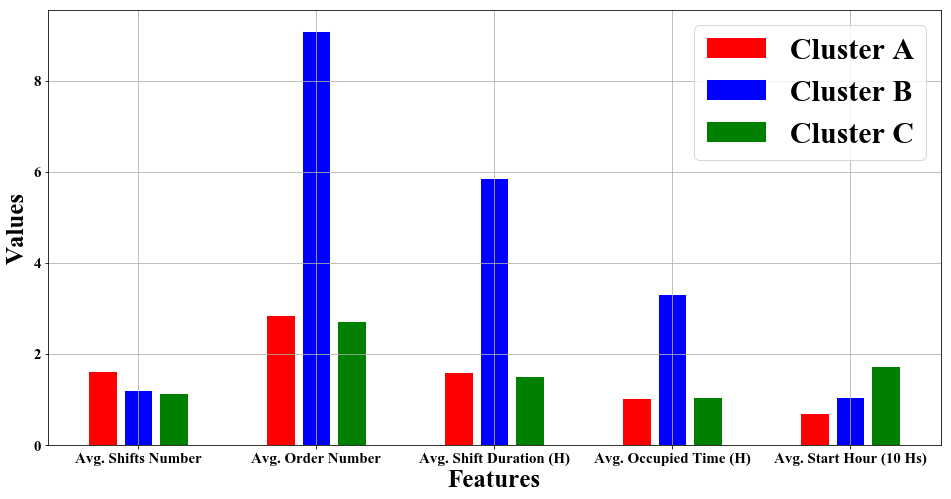

In [8]:
figsize = 16,8
figure,ax1 = plt.subplots(figsize=figsize)
font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 15}
font_title = {'family' : 'Times New Roman','weight' : 'normal','size': 30}
plt.tick_params(labelsize=15)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size': 25}


font_legend = {'weight' : 'normal',\
        'family' : 'Times New Roman',\
        'size': 30}
interval=[i for j in range(5) for i in range(10)]

coulmns=list(Stat[['Total Number of Shifts', 'Average Order Number','Average Shift Duration (hour)',\
           'Average Occupied Time (hour)','First Shift Start Time (x10 hours)']].columns)

Colors=['r','b','g']

Features=['Avg. Shifts Number','Avg. Order Number','Avg. Shift Duration (H)','Avg. Occupied Time (H)','Avg. Start Hour (10 Hs)']

for i in range(len(coulmns)):
    
    for j in range(len(Labels)):
        
        if i == len(coulmns)-1:
            
            ax1.bar(j+1+(i*5), Stat[coulmns[i]].iloc[j], label='Cluster '+Labels[j],fc = Colors[j],width = 0.8, edgecolor='white')
            
        else:
            
            ax1.bar(j+1+(i*5), Stat[coulmns[i]].iloc[j], fc = Colors[j],width = 0.8, edgecolor='white')
            
            
    
    
ax1.set_xticks(np.linspace(2,22,5))
ax1.set_xticklabels(Features)

ax1.legend(loc="upper right",prop=font_legend,numpoints=3)

ax1.set_xlabel('Features',font)
ax1.set_ylabel('Values',font)

plt.grid()
plt.show()


In [9]:
# '''Driver Cluster'''

# Driver_Df=Feature_df[['Driver_id','label']]

# Driver_Df.to_csv(os.path.join(Summary_path,'Driver_Df.csv'))

# Driver_Df



,Driver_id,label
0,0000131d486b69eb77ab6e9e7cca9f4c,A
1,000049d47b79747ad9927ba1bf5f4126,A
2,00005adc52a78e1630cfb50e4bd0f89e,C
3,000079a54709c3ce262a21327bebc5a7,A
4,0000839aee24e6f8d7856b7d5a89d665,C
5,000088d299916f2e44ef335f3752ae61,A
6,0000a3c4817080300cf3ef7d58faaad1,A
7,0000beca799d88e6810faf33df585dec,C
8,0000dbe2f9b7a09864e39eb56a415726,B
9,0001213d9f0ff0a68bcf8fbd0ca4bda8,B


# Correlation Analysis

In [10]:
Feature_df=pd.read_csv(os.path.join(Summary_path,'Feature_df.csv'))

Feature_df=Feature_df[['Driver_id',\
                       'Total Number of Shifts',\
                       'Average Order Number',\
                       'Average Shift Duration (sec)',\
                       'Average Occupied Time (sec)',\
                       'First Shift Start Time',\
                       'Average Occupied Distance(m)',\
                       'Gap Between Shifts']]

Feature_df['Average Shift Duration (Hour)']=Feature_df.apply(lambda x:Get_3600(x['Average Shift Duration (sec)']),axis=1)

Feature_df['Average Occupied Time (Hour)']=Feature_df.apply(lambda x:Get_3600(x['Average Occupied Time (sec)']),axis=1)

Feature_df['First Shift Start Hour']=Feature_df.apply(lambda x:Get_hour(x['First Shift Start Time']),axis=1)

Driver_Df=pd.read_csv(os.path.join(Summary_path,'Driver_Df.csv'))

Driver_Df=Driver_Df[['Driver_id','label']]

Feature_df=Feature_df.merge(Driver_Df,on='Driver_id')

Feature_df



,Driver_id,Total Number of Shifts,Average Order Number,Average Shift Duration (sec),Average Occupied Time (sec),First Shift Start Time,Average Occupied Distance(m),Gap Between Shifts,Average Shift Duration (Hour),Average Occupied Time (Hour),First Shift Start Hour,label
0,0000131d486b69eb77ab6e9e7cca9f4c,1,3.000000,6303.000000,4535.000000,1477972625,13518.0,0.000000,1.75,1.26,11.950000,A
1,000049d47b79747ad9927ba1bf5f4126,2,5.500000,12117.000000,5876.500000,1478564670,21370.5,3.518889,3.37,1.63,8.400000,A
2,00005adc52a78e1630cfb50e4bd0f89e,1,4.000000,7083.000000,4029.000000,1478171399,18906.0,0.000000,1.97,1.12,19.150000,C
3,000079a54709c3ce262a21327bebc5a7,2,4.500000,11667.000000,7536.500000,1479086961,40874.0,2.587778,3.24,2.09,9.483333,A
4,0000839aee24e6f8d7856b7d5a89d665,1,4.000000,10666.000000,6821.000000,1478936982,35271.0,0.000000,2.96,1.89,15.816667,C
5,000088d299916f2e44ef335f3752ae61,2,2.000000,3134.000000,2737.500000,1479076039,18916.0,3.081667,0.87,0.76,6.450000,A
6,0000a3c4817080300cf3ef7d58faaad1,2,2.000000,3977.000000,2095.500000,1478881162,23792.5,2.130000,1.10,0.58,0.316667,A
7,0000beca799d88e6810faf33df585dec,1,2.000000,5562.000000,3476.000000,1478672876,13922.0,0.000000,1.54,0.97,14.450000,C
8,0000dbe2f9b7a09864e39eb56a415726,1,14.000000,38873.000000,26812.000000,1478906313,101784.0,0.000000,10.80,7.45,7.300000,B
9,0001213d9f0ff0a68bcf8fbd0ca4bda8,1,7.000000,13681.000000,7489.000000,1478654565,45402.0,0.000000,3.80,2.08,9.366667,B


In [11]:
'''Average Shift Duration (Hour)'''

Feature_A=Feature_df.loc[(Feature_df['label']=='A')]

r,p = pearsonr(Feature_A['First Shift Start Hour'],Feature_A['Average Shift Duration (Hour)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))


Feature_B=Feature_df.loc[(Feature_df['label']=='B')]

r,p = pearsonr(Feature_B['First Shift Start Hour'],Feature_B['Average Shift Duration (Hour)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

Feature_C=Feature_df.loc[(Feature_df['label']=='C')]

r,p = pearsonr(Feature_C['First Shift Start Hour'],Feature_C['Average Shift Duration (Hour)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))


r value =  0.045，p value =  0.000
r value = -0.161，p value =  0.000
r value = -0.137，p value =  0.000


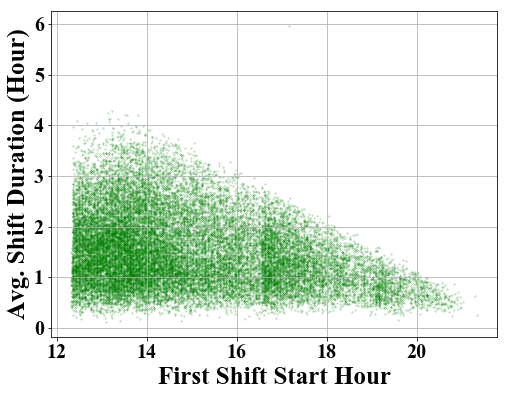

In [25]:
'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.scatter(Feature_C['First Shift Start Hour'],Feature_C['Average Shift Duration (Hour)'], c='g',alpha=0.2,marker='x',s=2)


ax1.set_ylabel('Avg. Shift Duration (Hour)',font_label)

ax1.set_xlabel('First Shift Start Hour',font_label)



xmajorLocator   = MultipleLocator(2)

ax1.xaxis.set_major_locator(xmajorLocator) 




plt.grid()

plt.show()



In [26]:
'''Gap Between Shifts'''

Feature_A=Feature_df.loc[(Feature_df['label']=='A')&((Feature_df['Gap Between Shifts']!=0))]

r,p = pearsonr(Feature_A['First Shift Start Hour'],Feature_A['Gap Between Shifts'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

Feature_B=Feature_df.loc[(Feature_df['label']=='B')&((Feature_df['Gap Between Shifts']!=0))]

r,p = pearsonr(Feature_B['First Shift Start Hour'],Feature_B['Gap Between Shifts'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

Feature_C=Feature_df.loc[(Feature_df['label']=='C')&((Feature_df['Gap Between Shifts']!=0))]

r,p = pearsonr(Feature_C['First Shift Start Hour'],Feature_C['Gap Between Shifts'])

print('r value = %6.3f，p value = %6.3f'%(r,p))



r value = -0.641，p value =  0.000
r value = -0.268，p value =  0.000
r value = -0.311，p value =  0.000


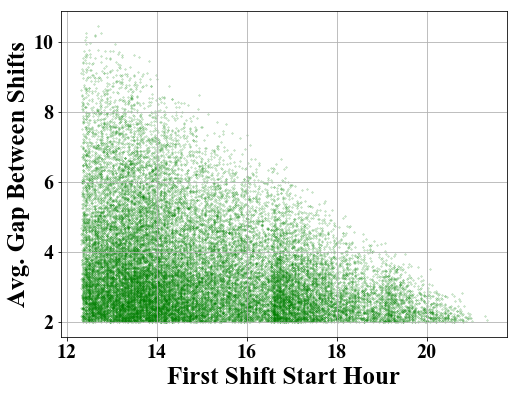

In [29]:
'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.scatter(Feature_C['First Shift Start Hour'],Feature_C['Gap Between Shifts'], c='g',alpha=0.2,marker='x',s=2)


ax1.set_ylabel('Avg. Gap Between Shifts',font_label)

ax1.set_xlabel('First Shift Start Hour',font_label)



xmajorLocator   = MultipleLocator(2)

ax1.xaxis.set_major_locator(xmajorLocator) 




plt.grid()

plt.show()



In [30]:
Summary=pd.read_csv(os.path.join(Summary_path,'Summary.csv'))

Summary=Summary[['Driver_id', 'Shifts', 'Order Number', 'Shift Duration (sec)', 'Occupied Time (sec)', 'Start Time','End Time','Occupied Distance(m)']]

Driver_Df=pd.read_csv(os.path.join(Summary_path,'Driver_Df.csv'))

Driver_Df=Driver_Df[['Driver_id','label']]

Summary=Summary.merge(Driver_Df,on='Driver_id')

Summary['Start Hour']=Summary.apply(lambda x:(Get_hour(x['Start Time'])),axis=1)

Summary['End Hour']=Summary.apply(lambda x:(Get_hour(x['End Time'])),axis=1)

Summary['Shift Duration (h)']=Summary.apply(lambda x:Get_3600(x['Shift Duration (sec)']),axis=1)

Summary

,Driver_id,Shifts,Order Number,Shift Duration (sec),Occupied Time (sec),Start Time,End Time,Occupied Distance(m),label,Start Hour,End Hour,Shift Duration (h)
0,0000131d486b69eb77ab6e9e7cca9f4c,1,3,6303,4535,1477972625,1477978928,13518,A,11.950000,13.700000,1.75
1,000211a97ba2b768ef941593bf1ae1a5,1,1,966,966,1477963781,1477964747,4914,A,9.483333,9.750000,0.27
2,000211a97ba2b768ef941593bf1ae1a5,1,4,6251,8455,1478002015,1478008266,33656,A,20.100000,21.850000,1.74
3,000770ada4aa5d856b5a766fb6bf7cf1,1,5,11649,5274,1477962292,1477973941,26231,A,9.066667,12.316667,3.24
4,0007a380800445346fff19afc4071ce3,1,1,1419,1419,1477963840,1477965259,5453,A,9.500000,9.900000,0.39
5,0008c9d2ac91c00ef8b3ef80eba02a06,1,3,4074,2729,1477967006,1477971080,16418,A,10.383333,11.516667,1.13
6,0008c9d2ac91c00ef8b3ef80eba02a06,1,2,3937,3431,1477984364,1477988301,19661,A,15.200000,16.300000,1.09
7,0008c9d2ac91c00ef8b3ef80eba02a06,1,3,10959,2406,1478005496,1478016455,15709,A,21.066667,0.116667,3.04
8,00095da02ea38d4d8eaa120201e38ae9,1,1,1522,1522,1477965144,1477966666,5050,A,9.866667,10.283333,0.42
9,000d0e4bd461b1f964daeb6d21868757,1,5,7148,5668,1477940181,1477947329,48705,A,2.933333,4.916667,1.99


In [39]:
Summary=Summary.sort_values(by=['Driver_id','Start Time'])

Gap_Df=pd.DataFrame([])

Gap_Df['Start Time']=Summary.groupby('Driver_id').apply(lambda x: x['Start Time'].to_list())

Gap_Df['End Time']=Summary.groupby('Driver_id').apply(lambda x: x['End Time'].to_list())

Gap_Df['Driver_id']=Gap_Df.index

def get_gap(Start,End):
    gap=list()
    if len(Start)==1:
        return gap
    else:
        for i in range(1,len(Start),1):
            gap.append([End[i-1],(Start[i]-End[i-1])/3600.0])
        return gap

Gap_Df['Gaps']=Gap_Df.apply(lambda x:get_gap(x['Start Time'],x['End Time']),axis=1)

Gap_Df['Length']=Gap_Df.apply(lambda x:len(x['Gaps']),axis=1)

Gap_Df=Gap_Df.loc[Gap_Df['Length']>0]

Gap_Df=Gap_Df.reset_index(drop=True)

Gap_Df = Gap_Df[['Driver_id','Gaps']]

Gap_Df=explode(Gap_Df,'Gaps')

Gap_Df['End Time']=Gap_Df.apply(lambda x:x['Gaps'][0],axis=1)

Gap_Df['Gap']=Gap_Df.apply(lambda x:x['Gaps'][1],axis=1)

Gap_Df['End Hour']=Gap_Df.apply(lambda x:(Get_hour(x['End Time'])),axis=1)


Gap_Df

,Driver_id,Gaps,End Time,Gap,End Hour
0,000049d47b79747ad9927ba1bf5f4126,"[1478578220, 3.5188888888888887]",1478578220,3.518889,12.166667
1,000079a54709c3ce262a21327bebc5a7,"[1479107376, 2.5877777777777777]",1479107376,2.587778,15.150000
2,000088d299916f2e44ef335f3752ae61,"[1479078296, 3.0816666666666666]",1479078296,3.081667,7.066667
3,0000a3c4817080300cf3ef7d58faaad1,"[1478882356, 2.13]",1478882356,2.130000,0.650000
4,0001860739024029fa3da2cad0ed4de2,"[1478741063, 5.519444444444445]",1478741063,5.519444,9.400000
5,000211a97ba2b768ef941593bf1ae1a5,"[1477964747, 10.352222222222222]",1477964747,10.352222,9.750000
6,0002615214db671062353e9d00a6ea89,"[1478660742, 2.4758333333333336]",1478660742,2.475833,11.083333
6,0002615214db671062353e9d00a6ea89,"[1478682471, 4.8475]",1478682471,4.847500,17.116667
7,000279f20291f5c67614f0c5c1e70097,"[1479099423, 3.39]",1479099423,3.390000,12.950000
7,000279f20291f5c67614f0c5c1e70097,"[1479112861, 2.794722222222222]",1479112861,2.794722,16.683333


In [32]:
'''Start Hour and Shift Duration'''

Summary_A=Summary.loc[(Summary['label']=='A')]

r,p = pearsonr(Summary_A['Start Hour'],Summary_A['Shift Duration (h)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

Summary_B=Summary.loc[Summary['label']=='B']

r,p = pearsonr(Summary_B['Start Hour'],Summary_B['Shift Duration (h)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

Summary_C=Summary.loc[Summary['label']=='C']

r,p = pearsonr(Summary_C['Start Hour'],Summary_C['Shift Duration (h)'])

print('r value = %6.3f，p value = %6.3f'%(r,p))

r value =  0.160，p value =  0.000
r value = -0.337，p value =  0.000
r value = -0.122，p value =  0.000


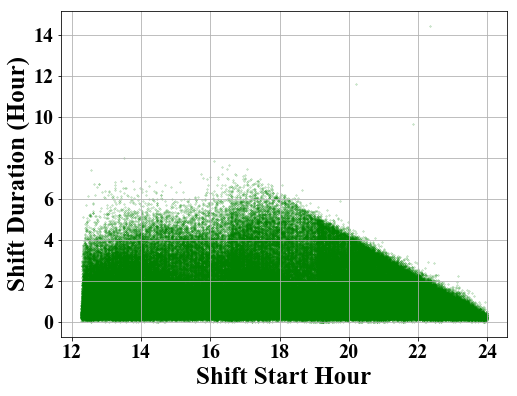

In [36]:
'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.scatter(Summary_C['Start Hour'],Summary_C['Shift Duration (h)'], c='g',alpha=0.2,marker='x',s=2)


ax1.set_ylabel('Shift Duration (Hour)',font_label)

ax1.set_xlabel('Shift Start Hour',font_label)


xmajorLocator   = MultipleLocator(2)

ax1.xaxis.set_major_locator(xmajorLocator) 




plt.grid()

plt.show()



In [42]:
Gap_Df=Gap_Df.merge(Driver_Df,on='Driver_id')


'''End Hour and Shift GAP'''

Gap_A=Gap_Df.loc[(Gap_Df['label']=='A')]

r,p = pearsonr(Gap_A['End Hour'],Gap_A['Gap'])

print('r value = %6.3f，p value = %6.3f'%(r,p))


Gap_B=Gap_Df.loc[(Gap_Df['label']=='B')]

r,p = pearsonr(Gap_B['End Hour'],Gap_B['Gap'])

print('r value = %6.3f，p value = %6.3f'%(r,p))


Gap_C=Gap_Df.loc[(Gap_Df['label']=='C')]

r,p = pearsonr(Gap_C['End Hour'],Gap_C['Gap'])

print('r value = %6.3f，p value = %6.3f'%(r,p))


r value = -0.648，p value =  0.000
r value = -0.257，p value =  0.000
r value = -0.365，p value =  0.000


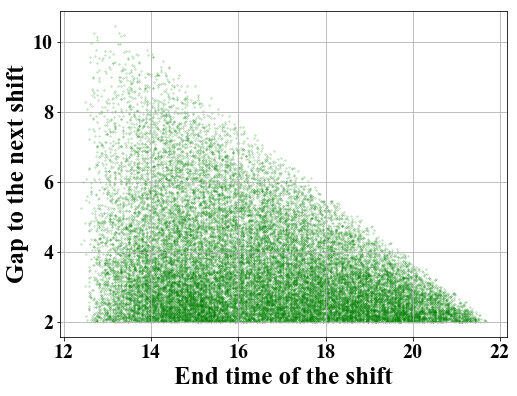

In [45]:
'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.scatter(Gap_C['End Hour'],Gap_C['Gap'], c='g',alpha=0.2,marker='x',s=2)


ax1.set_ylabel('Gap to the next shift',font_label)

ax1.set_xlabel('End time of the shift',font_label)


xmajorLocator   = MultipleLocator(2)

ax1.xaxis.set_major_locator(xmajorLocator) 




plt.grid()

plt.show()

